# Exemplos de Analíse de Componentes Principais Não Linear (NLPCA)

Luiz Felipe da S. Coelho -- luizfelipe.coelho@smt.ufrj.br

Abr 26, 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from src import NLPCA, PrincipalCurve

%load_ext autoreload
%autoreload 2

2024-04-29 13:14:47.375348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exemplo 1:
Duas variáveis $x_0 = 0,8 \textrm{sen}(\theta)$ e $x_1 = 0,8 \textrm{cos}(\theta)$, com $\theta = U[0, 2\pi]$.

Apesar de não ser possível representar $x_2$ como uma função de $x_1$, o NLPCA deve ser capaz de modelar os dados usando um fator não linear. Nesse exemplo apresentamos 2 métodos para representar o sinal multivariado usando apenas um fator.

### Visualização dos dados:

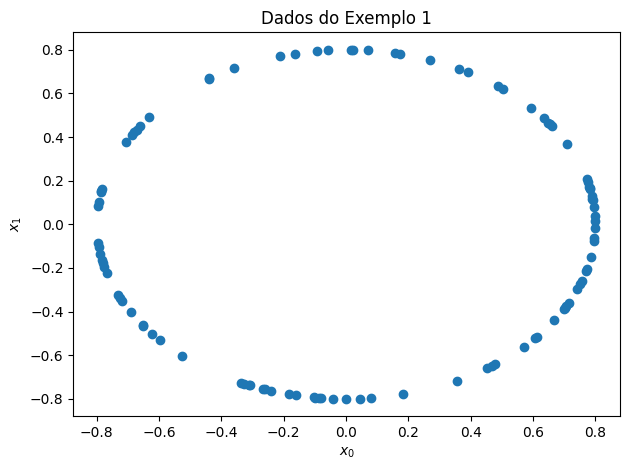

In [4]:
K = int(.5*1e6)
theta = 2*np.pi*np.random.random(K)
x0 = .8*np.sin(theta)
x1 = .8*np.cos(theta)

fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.scatter(x0[:100], x1[:100])
ax0.set_xlabel('$x_0$')
ax0.set_ylabel('$x_1$')
ax0.set_title('Dados do Exemplo 1')
fig0.tight_layout()

In [5]:
X = np.vstack((x0, x1))
X.shape

(2, 500000)

### Treinamento

2024-04-28 15:07:28.054460: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (34)


Epoch 1/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1873 - val_loss: 0.1596
Epoch 2/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1105 - val_loss: 0.0301
Epoch 3/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0274 - val_loss: 0.0204
Epoch 4/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0189 - val_loss: 0.0163
Epoch 5/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0155 - val_loss: 0.0132
Epoch 6/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0133 - val_loss: 0.0121
Epoch 7/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0122 - val_loss: 0.0132
Epoch 8/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0128 - val_loss: 0.0105
Epoch 9/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 10/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 11/250
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 12/250
1600/1

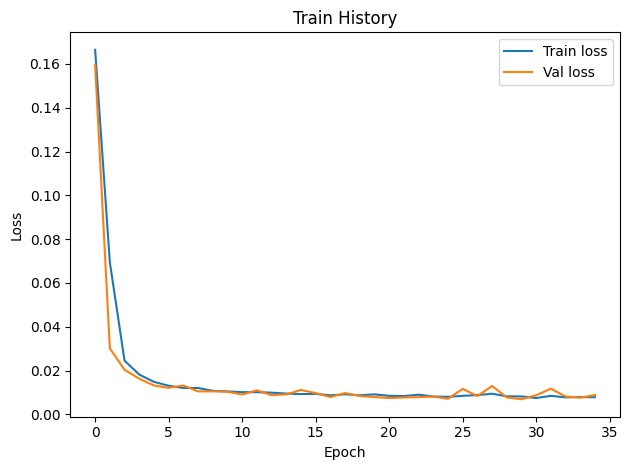

In [3]:
X = np.vstack((x0, x1))
nlpca_nn = NLPCA(num_variables=2, force_reduction=True)
pca = PCA(n_components=1)
pca.fit(X.T)
hist = nlpca_nn.fit(X.T, tune_flag=True)
# Plot train history
fig2 = plt.figure()
ax0 = fig2.add_subplot(111)
ax0.plot(hist['loss'], label='Train loss')
ax0.plot(hist['val_loss'], label='Val loss')
ax0.set_title('Train History')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.legend()
fig2.tight_layout()


### Teste

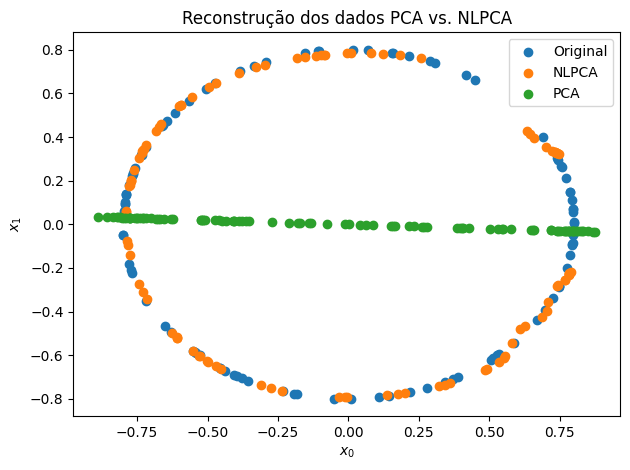

In [8]:
# Create test set:
K_test = 100
sigma_n2 = 1e-3
theta_test = 2*np.pi*np.random.random(K_test)
x0_test = .8*np.sin(theta_test)
x1_test = .8*np.cos(theta_test)
X_test = np.vstack((x0_test + np.sqrt(sigma_n2)*np.random.randn(K_test),
                    x1_test + np.sqrt(sigma_n2)*np.random.randn(K_test)))

# Test using trained models:
T = nlpca_nn.compress(X_test.T)
T_pca = pca.transform(X_test.T)
X_hat = nlpca_nn.decompress(np.array(T))
X_hat_pca = pca.inverse_transform(T_pca)

# Plot results
fig1 = plt.figure()
ax0 = fig1.add_subplot(111)
ax0.scatter(x0_test, x1_test, label='Original')
ax0.scatter(X_hat[:, 0], X_hat[:, 1], label='NLPCA')
ax0.scatter(X_hat_pca[:, 0], X_hat_pca[:, 1], label='PCA')
ax0.set_xlabel('$x_0$')
ax0.set_ylabel('$x_1$')
ax0.set_title('Reconstrução dos dados PCA vs. NLPCA')
ax0.legend()
fig1.tight_layout()


## Exemplo 2

Aproximação por curvas principais. Nesse exemplo usamos curvas principais para aproximar um conjunto de dados não linear.

In [2]:
x = load_breast_cancer()

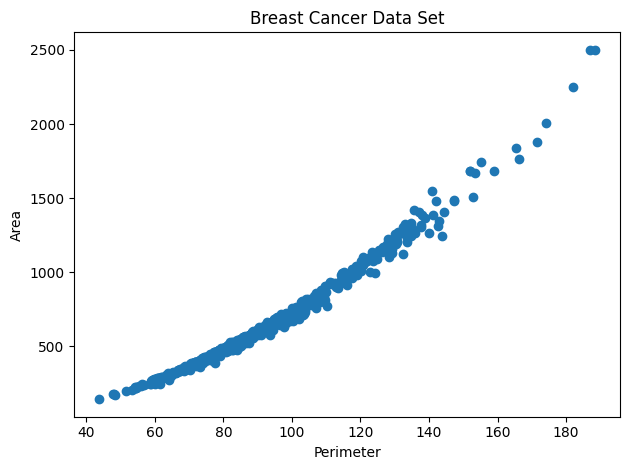

In [3]:
X = x['data'][:, (2, 3)]
fig2 = plt.figure()
ax0 = fig2.add_subplot(111)
ax0.scatter(X[:, 0], X[:, 1])
ax0.set_xlabel('Perimeter')
ax0.set_ylabel('Area')
ax0.set_title('Breast Cancer Data Set')
fig2.tight_layout()


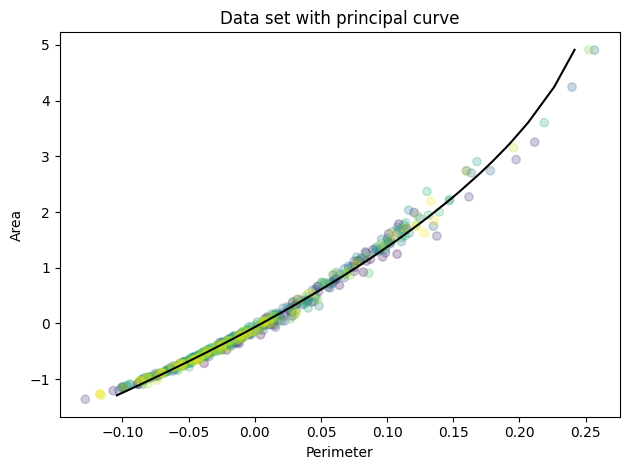

In [9]:
x_norm = (X - X.mean(axis=0))/X.std(ddof=0)
idx = np.arange(0, len(x_norm))
p = PrincipalCurve(k=2)
p.fit(x_norm)

fig3 = plt.figure()
ax0 = fig3.add_subplot(111)
ax0.scatter(x_norm[:, 0], x_norm[:, 1], alpha=.25, c=idx)
ax0.plot(p.p[:, 0], p.p[:, 1], c='k')
ax0.set_xlabel('Perimeter')
ax0.set_ylabel('Area')
ax0.set_title('Data set with principal curve')
fig3.tight_layout()